# Data Driven Feature Selection for Neutrophil % Prediction

Using mutual information (MI) to identify highly explanatory genes for neutrophil % in PPMI whole blood samples. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [13]:
# read in training set vst counts  for all passing genes
vstCounts = pd.read_csv("vstCounts_dev.csv")

In [17]:
vstCounts.head()

,geneID,ENSG00000242268.2,ENSG00000259041.1,ENSG00000207641.1,ENSG00000270112.3,ENSG00000280143.1,ENSG00000269416.5,ENSG00000263642.1,ENSG00000225275.4,ENSG00000158486.13,...,ENSG00000009694.13,ENSG00000238244.3,ENSG00000216352.1,ENSG00000123685.8,ENSG00000267117.1,ENSG00000265520.1,ENSG00000105063.18,ENSG00000181518.4,ENSG00000231119.2,ENSG00000178921.13
geneID,,,,,,,,,,,,,,,,,,,,,
PP-3000-SVM36T1,PP-3000-SVM36T1,6.009191,6.009191,6.009191,6.009191,6.436606,6.171245,6.777665,6.009191,6.465880,...,8.622332,6.171245,6.009191,7.266166,6.009191,6.289583,9.816904,6.009191,6.009191,7.943686
PP-3002-SVM36T1,PP-3002-SVM36T1,6.009191,6.184754,6.009191,6.257321,6.705108,6.009191,7.081407,6.009191,6.503640,...,8.978708,6.009191,6.009191,7.476579,6.009191,6.400800,10.024615,6.184754,6.257321,8.021954
PP-3003-SVM24T1,PP-3003-SVM24T1,6.009191,6.009191,6.009191,6.343760,6.995810,6.221075,7.259675,6.343760,6.721125,...,9.384119,6.009191,6.159083,7.259675,6.221075,6.159083,10.566513,6.159083,6.308572,8.406321
PP-3003-SVM36T1,PP-3003-SVM36T1,6.344130,6.009191,6.009191,6.923309,6.751600,6.395657,6.798417,6.202857,7.633693,...,9.675423,6.282871,6.202857,7.228607,6.009191,6.282871,9.880727,6.701331,6.554127,7.816974
PP-3004-SVM24T1,PP-3004-SVM24T1,6.009191,6.168005,6.009191,6.233674,6.556330,6.233674,7.006622,6.168005,6.677332,...,10.440820,6.168005,6.009191,7.233316,6.009191,6.009191,9.992280,6.168005,6.233674,7.683072


In [15]:
vstCounts = vstCounts.rename(columns={"Unnamed: 0":"geneID"})

In [16]:
# make geneID the index
vstCounts.index = vstCounts['geneID']

In [20]:
# read in training set metadata for known neutrophil % 
metaData = pd.read_csv("/Users/kxu/Library/CloudStorage/OneDrive-CityofHopeNationalMedicalCenter/CraigLab/Xu/PD Whole Blood DE/PD_FINAL_2/data/metaDev.csv")

In [22]:
metaData

,Unnamed: 0,sample_id,HudAlphaSampleName,ha_id,patno,visit,study.x,phase,Var.8,.1,...,Position,highestScore,enrichedScore,elevatedScore,neutScoHighest,neutScoEnriched,neutScoElevated,TotalScore,TotalDispersion,gsva_es
0,PP-3000-SVM36T1,PP-3000-SVM36T1,5104-SL-0396,5104-SL-0396,3000,V08,PPMI,1,354,#REF!,...,12,711.951468,2318.723613,9878.951950,429.063085,1232.743990,5282.539437,0.295182,1992.6144,0.240879
1,PP-3002-SVM36T1,PP-3002-SVM36T1,5104-SL-0401,5104-SL-0401,3002,V08,PPMI,1,358,#REF!,...,17,689.791244,2262.072112,9747.291357,403.904391,1171.815284,5141.412413,0.261015,2455.1856,-0.570821
2,PP-3003-SVM24T1,PP-3003-SVM24T1,5104-SL-0781,5104-SL-0781,3003,V06,PPMI,1,729,#REF!,...,13,700.075697,2308.307956,9898.400760,417.339292,1230.332583,5340.630117,0.276819,1954.0668,-0.277689
3,PP-3003-SVM36T1,PP-3003-SVM36T1,5104-SL-0815,5104-SL-0815,3003,V08,PPMI,1,760,#REF!,...,47,699.590591,2297.632888,9826.253956,416.815920,1220.414901,5257.489227,0.280202,2467.0464,-0.311755
4,PP-3004-SVM24T1,PP-3004-SVM24T1,5104-SL-1739,5104-SL-1739,3004,V06,PPMI,1,1658,#REF!,...,19,720.045492,2378.397085,10166.061979,433.926877,1299.394020,5594.358019,0.293690,1912.5540,0.434575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,PP-4124-SVM36T1,PP-4124-SVM36T1,5104-SL-1063,5104-SL-1063,4124,V08,PPMI,1,1005,#REF!,...,7,733.861699,2399.261832,10196.032774,451.263486,1320.247720,5633.147445,0.317880,1672.3728,0.582370
1003,PP-4126-SVM24T1,PP-4126-SVM24T1,5104-SL-0066,5104-SL-0066,4126,V06,PPMI,1,64,#REF!,...,66,723.970547,2372.037094,10096.352452,439.973958,1295.953005,5520.048493,0.300819,1630.8600,0.436766
1004,PP-4126-SVM36T1,PP-4126-SVM36T1,5104-SL-0023,5104-SL-0023,4126,V08,PPMI,1,23,#REF!,...,23,716.267443,2342.625019,9966.629812,431.273579,1263.149377,5380.827672,0.297520,1954.0668,0.207822
1005,PP-4127-SVM12T1,PP-4127-SVM12T1,5104-SL-3588,5104-SL-3588,4127,V04,PPMI,2,3452,#REF!,...,31,707.585347,2310.258583,9877.913930,422.641549,1225.047080,5276.572121,0.279234,2489.2854,0.033186


In [23]:
# subset only PPMI patients from vstCounts, then transpose for analysis (X data)
allvstWcbc = vstCounts.loc[metaData['sample_id'],:]

In [28]:
allvstWcbc = allvstWcbc.drop(['geneID'], axis=1)

In [29]:
# create list (Y data) of neutrophil %
neutPerc = list(metaData['Neutrophils (%) (%)'])

In [30]:
### define function for MI based feature selection with SelectKBest
def select_features(X_train, y_train):
 # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
 # learn relationship from training data
    fs.fit(X_train, y_train)
    #transform train input data
    X_train_fs = fs.transform(X_train)
    #transform test input data
    return X_train_fs, fs
 

Feature 0: 0.014094
Feature 1: 0.004836
Feature 2: 0.000000
Feature 3: 0.000000
Feature 4: 0.026369
Feature 5: 0.004396
Feature 6: 0.123380
Feature 7: 0.012979
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.045751
Feature 11: 0.000000
Feature 12: 0.029994
Feature 13: 0.000000
Feature 14: 0.005394
Feature 15: 0.046622
Feature 16: 0.010497
Feature 17: 0.001561
Feature 18: 0.000000
Feature 19: 0.000000
Feature 20: 0.000876
Feature 21: 0.011677
Feature 22: 0.012337
Feature 23: 0.008186
Feature 24: 0.000000
Feature 25: 0.000000
Feature 26: 0.002210
Feature 27: 0.000000
Feature 28: 0.000000
Feature 29: 0.045847
Feature 30: 0.007935
Feature 31: 0.021332
Feature 32: 0.036693
Feature 33: 0.000000
Feature 34: 0.050413
Feature 35: 0.019029
Feature 36: 0.000000
Feature 37: 0.000000
Feature 38: 0.010766
Feature 39: 0.005330
Feature 40: 0.096375
Feature 41: 0.002990
Feature 42: 0.039916
Feature 43: 0.000000
Feature 44: 0.000000
Feature 45: 0.006229
Feature 46: 0.042675
Feature 47: 0.023233
Fe

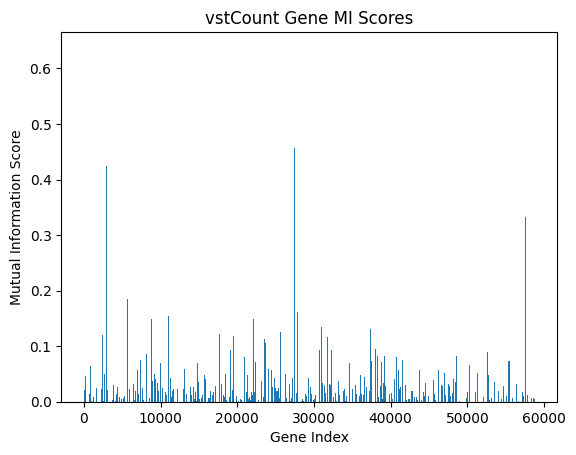

In [32]:
# feature selection
X_train_fs,fs = select_features(allvstWcbc, neutPerc)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel('Gene Index')
plt.ylabel('Mutual Information Score')
plt.title('vstCount Gene MI Scores')
plt.show()

In [48]:
# select genes with a score greater than 0.3
mi_genes = allvstWcbc.columns[fs.scores_ > 0.3]

In [49]:
len(mi_genes)


352

In [50]:
mi_genes

Index(['ENSG00000206344.7', 'ENSG00000078618.21', 'ENSG00000112303.13',
       'ENSG00000184014.7', 'ENSG00000057704.12', 'ENSG00000066336.11',
       'ENSG00000104870.12', 'ENSG00000155926.13', 'ENSG00000197852.10',
       'ENSG00000267365.1',
       ...
       'ENSG00000175538.10', 'ENSG00000101493.10', 'ENSG00000171049.8',
       'ENSG00000154845.15', 'ENSG00000188315.7', 'ENSG00000272953.1',
       'ENSG00000115561.15', 'ENSG00000065135.10', 'ENSG00000144909.7',
       'ENSG00000156052.10'],
      dtype='object', length=352)

In [51]:
import csv

In [52]:

with open('/Users/kxu/Library/CloudStorage/OneDrive-CityofHopeNationalMedicalCenter/CraigLab/Xu/PD Whole Blood DE/PD_FINAL_2/neutrophil_percent_prediction/mi_genes.txt', 'w') as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f)
     
    write.writerow(mi_genes)